# Abstract

To illustrate the functionality of **state_at_date.foo** in a *tidy* and concise manner, this example uses two shares denominated in USD, along with a set of transactions that include currency conversion to EUR, dividends, and transaction costs.

# Set Up

In [ ]:
# install tidyverse package
install.packages("tidyverse")

In [ ]:
# install quantmod package
install.packages("quantmod")

In [ ]:
# load R packages
library(tidyverse)
library(quantmod)

In [4]:
# load state_at_date function
source(url("https://raw.githubusercontent.com/iNANOV/transaction-state-simulator/main/state_at_date.R"))

# Processing

In [15]:
# Order book; price and cost are in EUR; yahoo tickers are in USD
order_book <- data.frame(
  yahoo_ticker = c("LIT", "AAPL", "LIT", "AAPL"), # in USD
  cash_initial = c(2888.40, 3019.20, 0, 0), # set to the exact amount of the investment
  date = as.Date(c("2022-06-29", "2023-04-19", "2024-04-17", "2024-05-31")),
  amount = c(40, 20, -10, -5), # >0 buy; <0 sell
  price = c(72.21, 150.96, 40.01, 177.42), # in EUR
  cost = c(7.9, 7.9, 7.9, 7.9) # in EUR
)

order_book

yahoo_ticker,cash_initial,date,amount,price,cost
<chr>,<dbl>,<date>,<dbl>,<dbl>,<dbl>
LIT,2888.4,2022-06-29,40,72.21,7.9
AAPL,3019.2,2023-04-19,20,150.96,7.9
LIT,0.0,2024-04-17,-10,40.01,7.9
AAPL,0.0,2024-05-31,-5,177.42,7.9


In [17]:
dividends <- data.frame(
  yahoo_ticker = c(rep("AAPL",10),"LIT"), # in USD
  date = as.Date(c("2023-05-19" ,"2023-07-11", "2023-08-18", "2023-11-19", "2024-01-10", "2024-02-05", "2024-05-16", "2024-07-10", "2024-08-15", "2024-11-15","2022-06-29")),
  dividend = c(3.31, 9.88, 3.28, 3.29, 17.04, 3.33, 3.44, 10.04, 3.15, 3.02, 0) # in EUR
)

dividends

yahoo_ticker,date,dividend
<chr>,<date>,<dbl>
AAPL,2023-05-19,3.31
AAPL,2023-07-11,9.88
AAPL,2023-08-18,3.28
AAPL,2023-11-19,3.29
AAPL,2024-01-10,17.04
AAPL,2024-02-05,3.33
AAPL,2024-05-16,3.44
AAPL,2024-07-10,10.04
AAPL,2024-08-15,3.15


In [19]:
# calculation of open positinions, cash, investment and performance state for each date
options(warn = -1)

# function for dowloading yahoo finance data in data frame format
yahoo_finance.foo <- function(ticker, From, To){
  # Download data and store it in variable `tab`
  tab <- getSymbols.yahoo(ticker, from = From, to = To, auto.assign = FALSE)

  # Rename the columns: remove the ticker prefix and make the first letter lowercase
  colnames(tab) <- tolower(sub(".*\\.", "", colnames(tab)))

  # Convert the index (dates) to a new 'date' column
  tab <- data.frame(symbol = ticker ,date = index(tab), coredata(tab))

  tab
}

tab <- order_book %>%
  nest(data = -yahoo_ticker) %>%
  mutate(
    stock_data = map2(
      yahoo_ticker,
      data,
      function(yahoo_ticker, data) {
        # exchange rate adjustment
        share <- yahoo_finance.foo(yahoo_ticker,
          From = min(data$date),
          To = Sys.Date() + 1)

        ex_rate <- yahoo_finance.foo("USDEUR=X",
          From = min(data$date),
          To = Sys.Date() + 1)

        left_join(share, ex_rate, by = ("date"="date")) %>%
            # fill missing exchange rates with the previous value
            fill(symbol.y,	open.y,	high.y,	low.y,	close.y,	volume.y,	adjusted.y, .direction = "down") %>%
            mutate(open = open.x * open.y, high = high.x * high.y,
                   low = low.x * low.y, close = close.x * close.y, adjusted = adjusted.x * adjusted.y) %>%
            rename(symbol = symbol.x, volume = volume.x) %>%
            dplyr::select(date, symbol, open, high, low, close, adjusted) %>%

          # Rename columns to capitalize the first letter, except for the 'date' column
          rename_with(
            .fn = ~ ifelse(
              .x == "date",
              .x,
              paste0(
                toupper(substr(.x, 1, 1)),
                tolower(substr(.x, 2, nchar(.x)))
              )
            ),
            .cols = everything()
          ) %>%
          # Join with the original data based on shared columns
          left_join(., data) %>%
          # Combine specific columns into a single column for performance tracking
          unite("Cap", Close, amount, price, sep = "_", remove = FALSE) %>%
          # Compute the state for each date using an accumulator function
          mutate(
            state = accumulate(
              Cap,
              function(acc, curr) {
                # Compute the state at a given date
                state_at_date.foo(acc, curr, initial_cash = data$cash_initial[1])
              },
              .init = list() # Initial empty list for the accumulator
            ) %>%
              tail(-1) # Remove the initial empty list from the result
          ) %>%
          # Remove the intermediate 'Cap' column
          dplyr::select(-Cap) %>%
          # Expand the 'state' column into wider columns
          unnest_wider(state) %>%
          # Add dividend information by joining with the 'dividends' table
          left_join(
            .,
            dividends,
            by = c("Symbol" = "yahoo_ticker", "date" = "date")
          ) %>%
          # Handle missing values in 'cost' and 'dividend' columns
          mutate(
            cost = case_when(is.na(cost) ~ 0, TRUE ~ cost),
            dividend = case_when(is.na(dividend) ~ 0, TRUE ~ dividend)
          ) %>%
          # Calculate cumulative sums for 'cost' and 'dividend'
          mutate(
            cost = cumsum(cost),
            dividend = cumsum(dividend)
          )
      }
    )
  ) %>%
  # Remove the original 'data' column
  dplyr::select(-data) %>%
  # Expand the 'stock_data' list-column into separate rows
  unnest(stock_data) %>%
  # Calculate the adjusted cash value
  mutate(adj_cash = cash - cost + dividend) %>%
  dplyr::select(-Symbol)

glimpse(tab)

Joining with `by = join_by(date)`
Joining with `by = join_by(date)`


Rows: 1,036
Columns: 17
$ yahoo_ticker   <chr> "LIT", "LIT", "LIT", "LIT", "LIT", "LIT", "LIT", "LIT",…
$ date           <date> 2022-06-29, 2022-06-30, 2022-07-01, 2022-07-05, 2022-0…
$ Open           <dbl> 70.29087, 68.66980, 68.24032, 68.82653, 70.67258, 72.21…
$ High           <dbl> 71.08124, 70.41537, 69.55712, 70.97880, 71.40525, 74.86…
$ Low            <dbl> 68.90118, 68.29615, 67.66625, 68.71780, 69.71190, 72.06…
$ Close          <dbl> 69.47721, 69.30926, 68.47892, 70.24985, 70.58423, 73.86…
$ Adjusted       <dbl> 67.72466, 67.56095, 66.75156, 68.47782, 68.80377, 72.00…
$ cash_initial   <dbl> 2888.4, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ amount         <dbl> 40, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ price          <dbl> 72.21, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ cost           <dbl> 7.9, 7.9, 7.9, 7.9, 7.9, 7.9, 7.9, 7.9, 7.9, 7.9, 7.9, …
$ open_positions <list> [<data.frame[40 x 3]>], [<data.frame[40 x 3]>], [<data…
$ investment    

In [20]:
dplyr::select(tab, -open_positions) %>%
  filter(date == Sys.Date()-1) %>%
  dplyr::select(- c(cash_initial, amount, price)) %>%
  mutate(across(where(is.numeric), ~ round(.x, 2)))

yahoo_ticker,date,Open,High,Low,Close,Adjusted,cost,investment,cash,performance,dividend,adj_cash
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LIT,2024-12-12,42.16,42.56,42.02,42.27,42.27,15.8,2166.3,400.1,-898.27,0.00,384.30
AAPL,2024-12-12,234.98,237.69,233.31,236.00,236.00,15.8,2264.4,887.1,1275.58,56.49,927.79


In [21]:
# show the 'open_positions' column which contains list with the open positons for each date
dplyr::select(tab, date, yahoo_ticker, open_positions) %>%
  unnest(open_positions) %>%
  filter(date == Sys.Date()-1) %>%
  group_by(date, yahoo_ticker, price) %>%
  summarise(CLose = mean(Close), n = n())

`summarise()` has grouped output by 'date', 'yahoo_ticker'. You can override
using the `.groups` argument.


date,yahoo_ticker,price,CLose,n
<date>,<chr>,<dbl>,<dbl>,<int>
2024-12-12,AAPL,150.96,235.99841,15
2024-12-12,LIT,72.21,42.26766,30


# Quering

`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


cash : initial cash + gains or loses of closed positions - investment;
 investment : invested capital in open positions;
 performance: performance from open positions


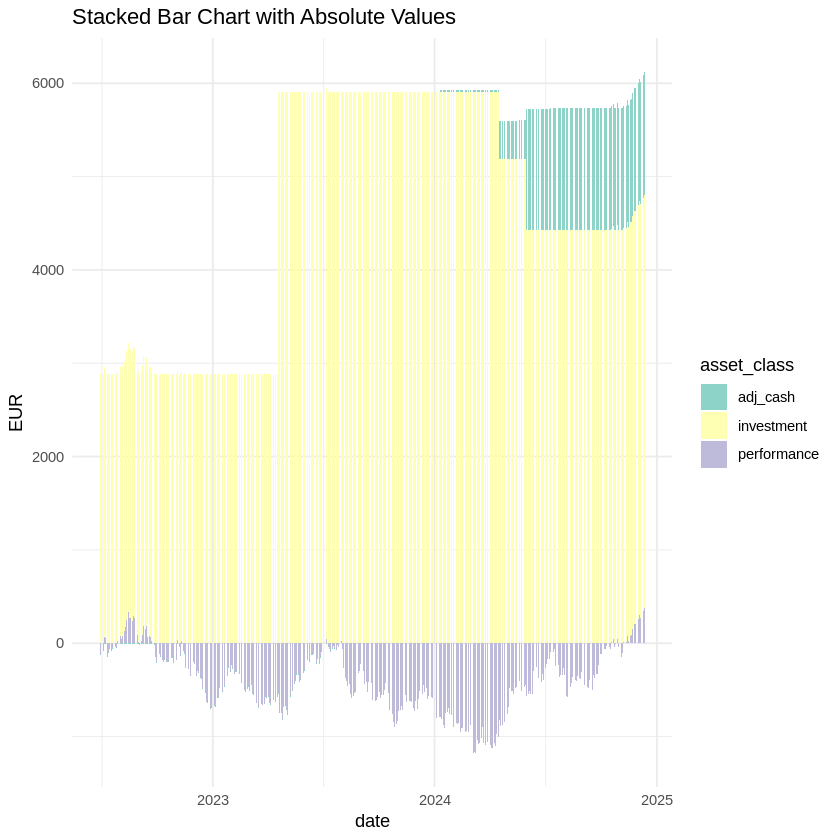

In [22]:
# Summarized asset classes distribution over time
  tab %>%
    dplyr::select(- open_positions) %>%
    pivot_longer(
      cols = c("investment", "adj_cash", "performance"), # Select columns to pivot
      names_to = "asset_class",        # New column for key names
      values_to = "eur"          # New column for values
    ) %>%
    group_by(date, asset_class) %>%
    summarise(EUR = sum(eur)) %>%
    ggplot(aes(x = date, y = EUR, fill = asset_class)) +
    geom_bar(stat = "identity") +  # Use raw values (absolute)
    labs(title = "Stacked Bar Chart with Absolute Values") +
  scale_fill_brewer(palette = "Set3") +  # Optional: nice color palette
  theme_minimal()

cat("cash : initial cash + gains or loses of closed positions - investment;\n investment : invested capital in open positions;\n performance: performance from open positions\n")

`summarise()` has grouped output by 'yahoo_ticker', 'date', 'Adjusted',
'cash_initial', 'amount', 'price', 'cost', 'investment', 'cash', 'performance',
'dividend'. You can override using the `.groups` argument.
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


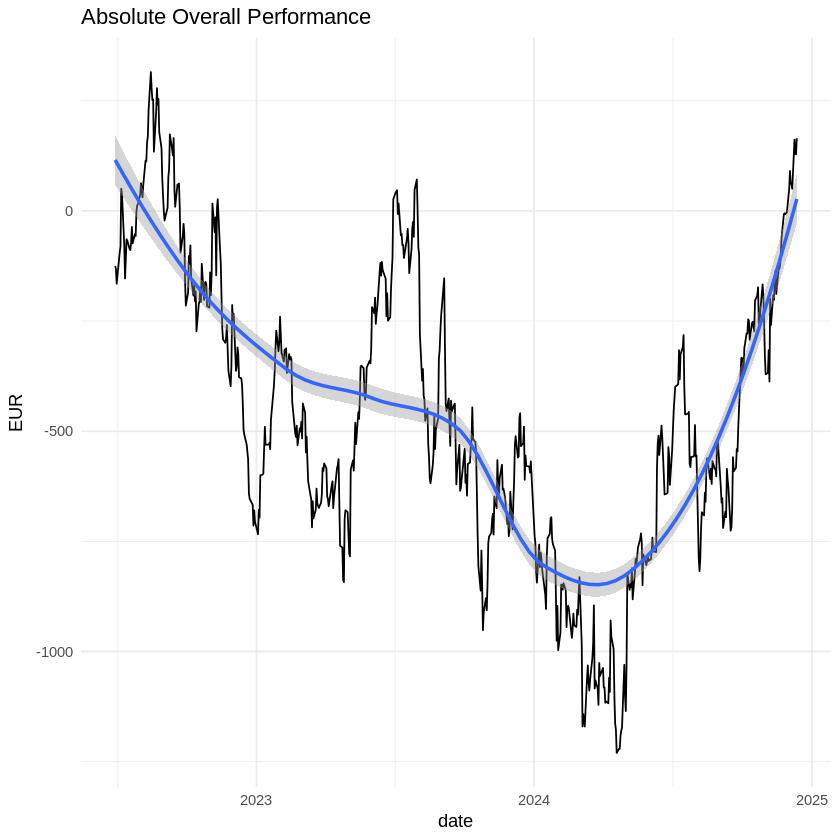

In [70]:
# Absolute Overall Performance
tab %>%
  dplyr::select(- open_positions) %>%
  group_by(yahoo_ticker, date, Adjusted, cash_initial,	amount,	price,	cost,	investment,	cash,	performance,	dividend,	adj_cash) %>%
  summarise(initial_cash = cash_initial + cost) %>%
  mutate(initial_cash = case_when(is.na(initial_cash) ~ 0, !is.na(initial_cash) ~ initial_cash)) %>%
  ungroup() %>%
  group_by(yahoo_ticker) %>%
  mutate(cum_initial_cash = cumsum(initial_cash)) %>%
  ungroup() %>%
  mutate(eur = investment + adj_cash + performance) %>%
  group_by(date) %>%
  summarise(Eur = sum(eur), InitCash = sum(cum_initial_cash)) %>%
  mutate(EUR = Eur - InitCash) %>%
  ggplot(aes(x = date, y = EUR)) +
  geom_line() +
  geom_smooth() +
  labs(title = "Absolute Overall Performance") +
  theme_minimal()

`summarise()` has grouped output by 'yahoo_ticker', 'date', 'Adjusted',
'cash_initial', 'amount', 'price', 'cost', 'investment', 'cash', 'performance',
'dividend'. You can override using the `.groups` argument.
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


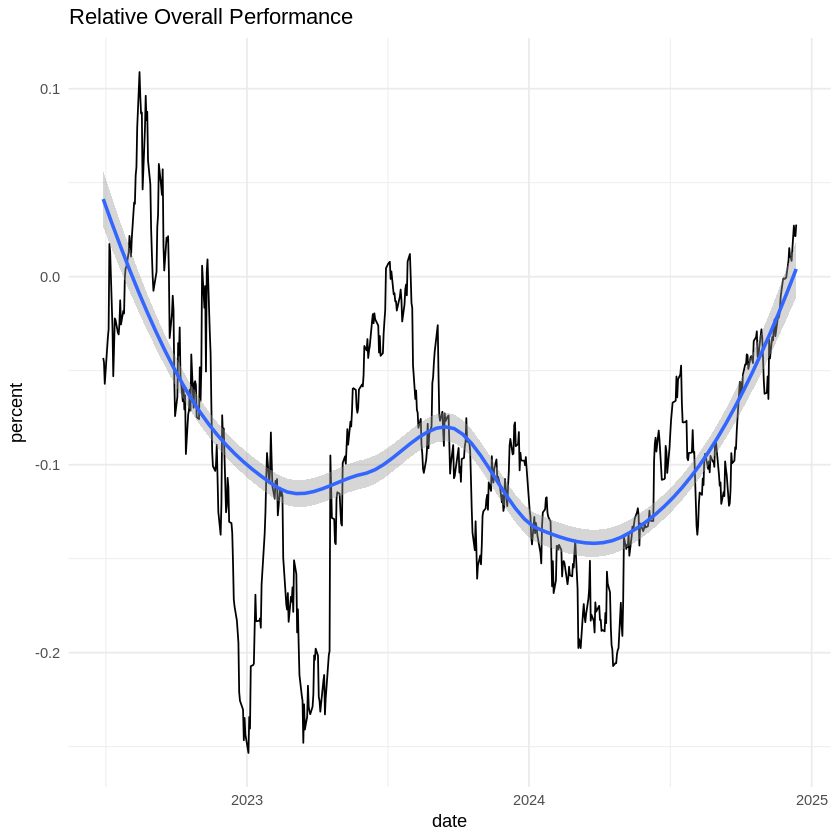

In [26]:
# Relative Overall Performance
tab %>%
  dplyr::select(- open_positions) %>%
  group_by(yahoo_ticker, date, Adjusted, cash_initial,	amount,	price,	cost,	investment,	cash,	performance,	dividend,	adj_cash) %>%
  summarise(initial_cash = cash_initial + cost) %>%
  mutate(initial_cash = case_when(is.na(initial_cash) ~ 0, !is.na(initial_cash) ~ initial_cash)) %>%
  ungroup() %>%
  group_by(yahoo_ticker) %>%
  mutate(cum_initial_cash = cumsum(initial_cash)) %>%
  ungroup() %>%
  mutate(eur = investment + adj_cash + performance) %>%
  group_by(date) %>%
  summarise(EUR = sum(eur), InitCash = sum(cum_initial_cash)) %>%
  mutate(percent = (EUR / InitCash) - 1 ) %>%
  ggplot(aes(x = date, y = percent)) +
  geom_line() +
  geom_smooth() +
  labs(title = "Relative Overall Performance") +
  theme_minimal()

`summarise()` has grouped output by 'yahoo_ticker', 'date', 'Adjusted',
'cash_initial', 'amount', 'price', 'cost', 'investment', 'cash', 'performance',
'dividend'. You can override using the `.groups` argument.
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


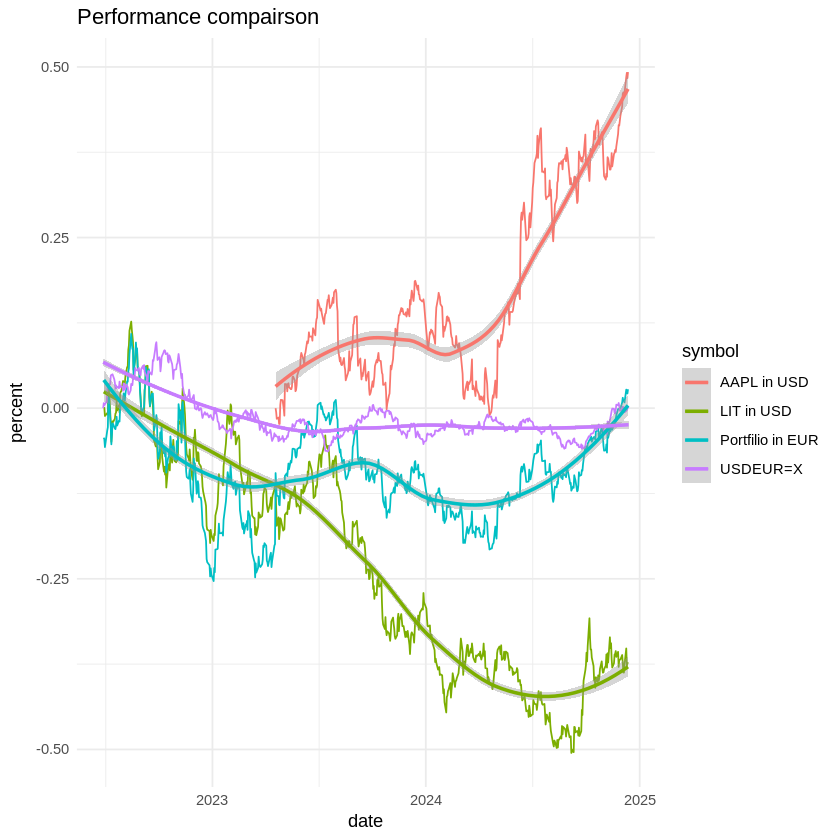

In [38]:
# Performance compairson
tab %>%
  # add relative overall performance
  dplyr::select(- open_positions) %>%
  group_by(yahoo_ticker, date, Adjusted, cash_initial,	amount,	price,	cost,	investment,	cash,	performance,	dividend,	adj_cash) %>%
  summarise(initial_cash = cash_initial + cost) %>%
  mutate(initial_cash = case_when(is.na(initial_cash) ~ 0, !is.na(initial_cash) ~ initial_cash)) %>%
  ungroup() %>%
  group_by(yahoo_ticker) %>%
  mutate(cum_initial_cash = cumsum(initial_cash)) %>%
  ungroup() %>%
  mutate(eur = investment + adj_cash + performance) %>%
  group_by(date) %>%
  summarise(EUR = sum(eur), InitCash = sum(cum_initial_cash)) %>%
  mutate(percent = (EUR / InitCash) - 1 ) %>%
  dplyr::select(date, percent) %>%
  mutate(symbol = "Portfilio in EUR") %>%
  # add initial stocks
  bind_rows(.,
    unique(order_book$yahoo_ticker) %>%
    map_dfr(~ yahoo_finance.foo(.x,
         From = filter(order_book, yahoo_ticker == .x) %>%
          pull(date) %>% min(),
         To = Sys.Date() + 1) %>%
           mutate(
              percent = ((adjusted - first(adjusted))/first(adjusted)),
              symbol = paste0(.x," in USD")
            ) %>%
              dplyr::select(date, percent, symbol))) %>%
  # add exchange rate
  bind_rows(.,
     yahoo_finance.foo("USDEUR=X",
         From = min(order_book$date),
         To = Sys.Date() + 1) %>%
           mutate(
              percent = ((adjusted - first(adjusted))/first(adjusted)),
              symbol = "USDEUR=X"
            ) %>%
              dplyr::select(date, percent, symbol)) %>%
  ggplot(aes(x = date, y = percent, col = symbol)) +
  geom_line() +
  geom_smooth() +
  labs(title = "Performance compairson") +
  theme_minimal()

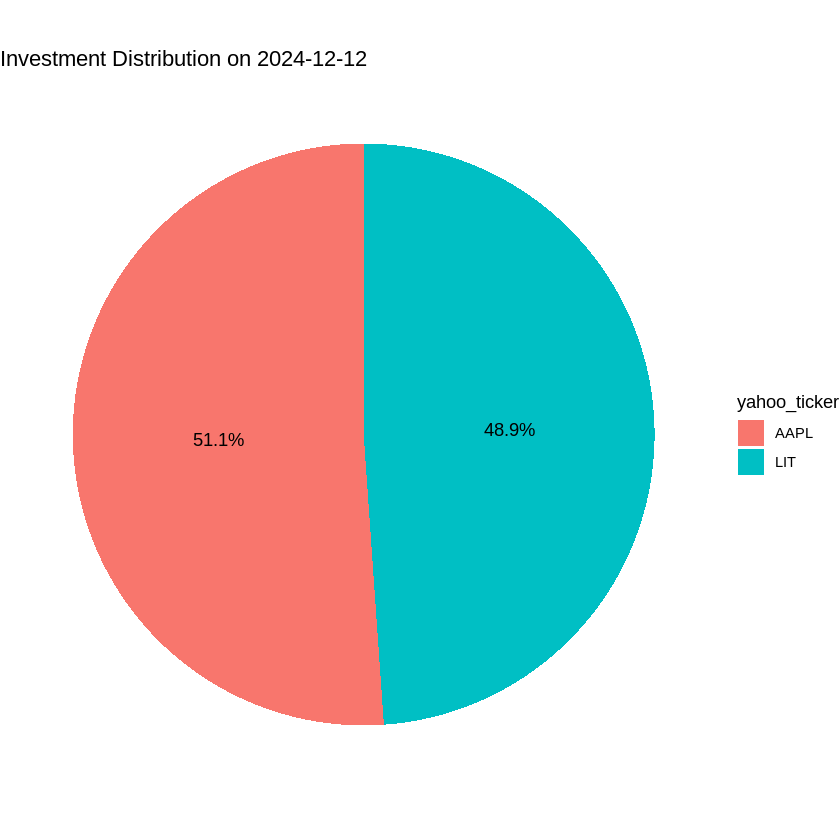

In [68]:
# Pie share graph of investments in open positions

refernece_date <- "2024-12-12"

tab %>%
  # Remove the open_positions column
  dplyr::select(date, yahoo_ticker, investment) %>%
  # Filter for the specific date of interest
  filter(date == refernece_date ) %>%
  # Calculate percentages for each investment
  mutate(percentage = investment / sum(investment) * 100,
         label = paste0(round(percentage, 1), "%")) %>%
  # Create the pie chart
  ggplot(aes(x = "", y = investment, fill = yahoo_ticker)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar(theta = "y") +
  theme_void() +
  geom_text(aes(label = label),
            position = position_stack(vjust = 0.5)) +
  labs(title = paste0("Investment Distribution on ", refernece_date))